# California Housing Dataset Description

This is a dataset that describes the median house value for California districts. Each data sample is a census block group. The target variable is the *median house value in USD 100,000 in 1990*, and there are 8 input features, each describing something about the house. They are, namely:

- **MedInc**: Median income in block group  
- **HouseAge**: Median house age in block group  
- **AveRooms**: Average number of rooms per household  
- **AveBedrms**: Average number of bedrooms per household  
- **Population**: Block group population  
- **AveOccup**: Average number of household members  
- **Latitude**: Block group centroid latitude  
- **Longitude**: Block group centroid longitude


In [14]:
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Fetch the data:

In [3]:
from sklearn.datasets import fetch_california_housing
 
data = fetch_california_housing()

In [4]:

# Create a DataFrame with feature names
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target column
df['Target'] = data.target

In [5]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Split the data:

In [6]:
X, y = data.data, data.target

# Building a Model and Train

## Neural Network Model Overview

This code defines a feedforward neural network using PyTorch's `nn.Sequential`. The model has 4 layers with 8 input features, hidden layers of sizes 24, 12, and 6, and a single output, using ReLU activation between layers.


In [7]:
import torch.nn as nn

# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

## Loss Function and Optimizer

We define the **Mean Squared Error (MSE)** as the loss function for regression tasks and uses the **Adam optimizer** with a learning rate of 0.0001 to update the model's parameters.


In [8]:
import torch.optim as optim

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Train-Test Split and Tensor Conversion

The dataset is split into training (70%) and testing (30%) sets using `train_test_split` with shuffling enabled. The features (`X`) and target (`y`) are then converted into PyTorch tensors with `float32` data type, ensuring the target tensors are reshaped to have one column.


In [9]:
# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

## Training Parameters

- **n_epochs**: The number of training epochs is set to 100, indicating the model will iterate through the entire training dataset 100 times.
- **batch_size**: Each batch contains 10 samples, used for mini-batch gradient descent.
- **batch_start**: A tensor is created to define the starting indices of each batch in the training data.


In [10]:
# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

## Tracking the Best Model

- **best_mse**: Initialized to infinity, this variable keeps track of the lowest Mean Squared Error (MSE) achieved during training.
- **best_weights**: Stores the weights of the model corresponding to the best MSE.
- **history**: An empty list to record the training progress, such as loss values for each epoch.


In [11]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

### Training Loop with Progress Display Every 10 Epochs

In this section, we train the model for a specified number of epochs and display progress every 10 epochs. The process involves:

1. **Epoch Progress**: The training loop prints the current epoch number every 10 epochs to track the training progress.
   
2. **Mini-Batch Training**: For each epoch, the model is trained using mini-batches of data. The batches are processed one by one, where:
   - **Forward Pass**: The model makes predictions based on the current batch of input data.
   - **Loss Calculation**: The loss function computes the difference between the predicted and actual values.
   - **Backward Pass**: The gradients are computed, and the model's weights are updated using the optimizer.

3. **Model Evaluation**: After each epoch, the model is evaluated on the test set, and the Mean Squared Error (MSE) is calculated to assess the model's performance.

4. **Best Model Saving**: The model with the lowest MSE is saved as the best model for future use. This ensures that the most accurate model is preserved.


In [16]:
# training loop with progress display every 10 epochs
for epoch in range(n_epochs):
    model.train()
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs}")
    
    for i, start in enumerate(batch_start):
        # take a batch
        X_batch = X_train[start:start + batch_size]
        y_batch = y_train[start:start + batch_size]
        
        # forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update weights
        optimizer.step()

    # evaluate accuracy at the end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())


Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100
Epoch 100/100


### Restoring the Best Model and Evaluating Performance

- **Restore Best Model**: The model weights with the lowest MSE are loaded to ensure the best version of the model is used.
- **Display Best MSE**: The lowest MSE achieved during training is printed.
- **Calculate RMSE**: The Root Mean Squared Error (RMSE) is calculated by taking the square root of the MSE for better interpretability.
- **Plot Training History**: The MSE values recorded at the end of each epoch are plotted to visualize the model's performance over time.


MSE: 0.45
RMSE: 0.67


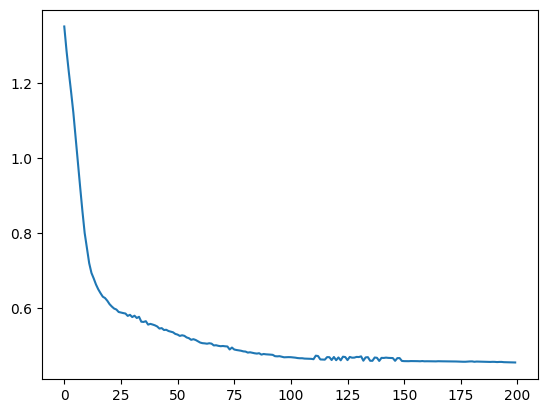

In [17]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

### Calculate MAPE (Mean Absolute Percentage Error)

1. **Define MAPE Function**: A function `mean_absolute_percentage_error` is defined to calculate the MAPE between true and predicted values.
2. **Get Predictions**: The model's predictions are obtained for the test data and detached from the computation graph using `.detach()`.
3. **Convert to NumPy Arrays**: Both the predictions (`y_pred`) and true values (`y_test`) are converted to NumPy arrays.
4. **Calculate MAPE**: The MAPE is calculated by passing the true and predicted values to the function and printed.

The MAPE metric gives a percentage error, which is useful for evaluating the model's performance.


In [19]:
# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Get predictions and detach from the computation graph
y_pred = model(X_test).detach().numpy()
y_test = y_test.detach().numpy()

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")


MAPE: 29.70%


### Making Predictions with the Trained Model

1. **Sample Input**: A sample input tensor is created using values similar to those from the dataset. The input consists of 8 features:
   - **MedInc**: Median income in the block group (e.g., 8.3252 represents $83,252).
   - **HouseAge**: Median house age in the block group (e.g., 32.0 means houses are 32 years old on average).
   - **AveRooms**: Average number of rooms per household (e.g., 6.984127 means each household has 6.98 rooms on average).
   - **AveBedrms**: Average number of bedrooms per household (e.g., 1.023810 means an average of 1.02 bedrooms).
   - **Population**: Population of the block group (e.g., 322.0 represents 322 people).
   - **AveOccup**: Average number of household members (e.g., 2.555556 means 2.56 members per household).
   - **Latitude**: Latitude of the block group (e.g., 37.88 represents latitude 37.88).
   - **Longitude**: Longitude of the block group (e.g., -122.23 represents longitude -122.23).

2. **Prediction**: The model is set to evaluation mode using `model.eval()` and the prediction is made with the sample input. 
   
3. **Output**: The predicted median house value is printed in USD 100,000.

This code provides a prediction based on the input features for a given block group.


In [23]:
# Sample input values (using similar values from your dataset)
# Format: [MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude]
sample_input = torch.tensor([[8.3252, 32.0, 6.984127, 1.023810, 322.0, 2.555556, 37.88, -122.23]], dtype=torch.float32)

# Make prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    prediction = model(sample_input)

# Print the prediction
print(f"Predicted house value: {prediction.item():.2f} (in USD 100,000)")


Predicted house value: 4.31 (in USD 100,000)
